In [1]:

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from scipy import signal
from seiz_eeg.dataset import EEGDataset
from sklearn.model_selection import train_test_split

# Ensure seiz_eeg is installed before importing


import os

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/mvukasin/nml_project/data/"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

In [3]:
train_clips.shape, val_clips.shape


((10167, 6), (2826, 6))

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [4]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [5]:
# Dependences
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [6]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [7]:
def spectrogram_transform_2d(x: np.ndarray, fs: int = 250, nperseg: int = 64, noverlap: int = 32) -> np.ndarray:
    """
    Compute the log-spectrogram for each channel, output shape: (channels, freq_bins, time_bins)
    """
    x_filt = signal.sosfiltfilt(bp_filter, x, axis=0)
    specs = []
    for ch in range(x_filt.shape[1]):
        f, t, Sxx = signal.spectrogram(x_filt[:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        Sxx_log = np.log(Sxx + 1e-8)
        specs.append(Sxx_log)
    specs = np.stack(specs, axis=0)  # shape: [channels, freq_bins, time_bins]
    return specs.astype(np.float32)


In [8]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=spectrogram_transform_2d,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=spectrogram_transform_2d,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

## Baseline: Spectogram features + CNN
The first baseline is a simple CNN model that uses spectrogram features as input. The model is trained on the training set and evaluated on the validation set.


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleEEGCNN(nn.Module):
    def __init__(self, num_channels, freq_bins, time_bins):
        super(SimpleEEGCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),  # [B,32,F,T]
            nn.ReLU(),
            nn.MaxPool2d(2),  # halve freq/time dims
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B,64,F/2,T/2]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B,64,F/4,T/4]
        )
        
        # Calculate flattened feature size after conv/pool
        fc_input_dim = (freq_bins // 4) * (time_bins // 4) * 64
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # binary output
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x


In [10]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


(19, 33, 92)


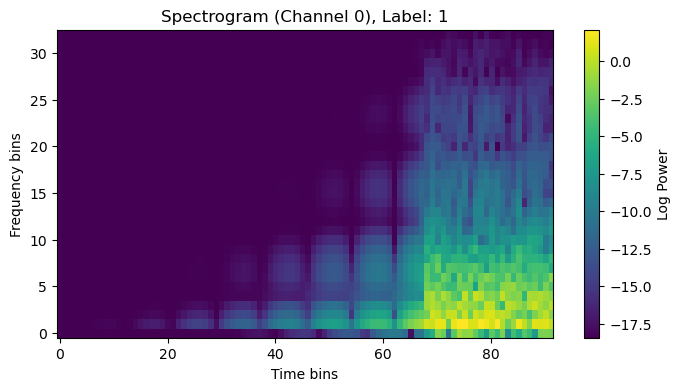

In [11]:
sample = train_dataset[0][0]  # shape: [channels, freq_bins, time_bins]
print(sample.shape)  # e.g., torch.Size([19, 33, 15]) or numpy shape (19, 33, 15)

num_channels = sample.shape[0]
freq_bins = sample.shape[1]
time_bins = sample.shape[2]

# Plot the spectrogram of the first channel of the first sample

sample_x, sample_y = train_dataset[0]  # sample_x shape: [channels, freq_bins, time_bins]
plt.figure(figsize=(8, 4))
plt.imshow(sample_x[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Log Power')
plt.title(f"Spectrogram (Channel 0), Label: {sample_y}")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.show()





In [12]:
class_weight = 4.0  # Adjust this based on your dataset

model = SimpleEEGCNN(num_channels, freq_bins, time_bins).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
from sklearn.metrics import f1_score
from tqdm import tqdm  # For progress bar

num_epochs = 100
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().to(device)  # [B, C, F, T]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    avg_loss = running_loss / len(loader_tr.dataset)
    train_losses.append(avg_loss)

    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            x_val = x_val.float().to(device)  # [B, C, F, T]
            y_val = y_val.float().unsqueeze(1).to(device)  # [B, 1]

            val_logits = model(x_val)
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item() * x_val.size(0)

            val_probs = torch.sigmoid(val_logits)
            val_preds = (val_probs > 0.5).int()

            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

    avg_val_loss = val_running_loss / len(loader_val.dataset)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_loss:.4f} — Val Loss: {avg_val_loss:.4f} — Val F1: {val_f1:.4f}")


Training:   1%|█                                                                                                               | 1/100 [00:07<11:56,  7.24s/it]

Epoch 1/100 — Train Loss: 1.0012 — Val Loss: 0.8676 — Val F1: 0.7125


Training:   2%|██▏                                                                                                             | 2/100 [00:09<07:12,  4.41s/it]

Epoch 2/100 — Train Loss: 0.7396 — Val Loss: 0.8246 — Val F1: 0.6812


Training:   3%|███▎                                                                                                            | 3/100 [00:12<05:40,  3.51s/it]

Epoch 3/100 — Train Loss: 0.6601 — Val Loss: 0.8163 — Val F1: 0.6906


Training:   4%|████▍                                                                                                           | 4/100 [00:14<04:55,  3.08s/it]

Epoch 4/100 — Train Loss: 0.6110 — Val Loss: 0.8303 — Val F1: 0.6956


Training:   5%|█████▌                                                                                                          | 5/100 [00:16<04:30,  2.85s/it]

Epoch 5/100 — Train Loss: 0.5562 — Val Loss: 0.9020 — Val F1: 0.7172


Training:   6%|██████▋                                                                                                         | 6/100 [00:19<04:14,  2.71s/it]

Epoch 6/100 — Train Loss: 0.5157 — Val Loss: 0.8449 — Val F1: 0.7402


Training:   7%|███████▊                                                                                                        | 7/100 [00:21<04:04,  2.63s/it]

Epoch 7/100 — Train Loss: 0.4802 — Val Loss: 0.8741 — Val F1: 0.7359


Training:   8%|████████▉                                                                                                       | 8/100 [00:24<03:56,  2.57s/it]

Epoch 8/100 — Train Loss: 0.4430 — Val Loss: 0.9940 — Val F1: 0.7354


Training:   9%|██████████                                                                                                      | 9/100 [00:26<03:50,  2.53s/it]

Epoch 9/100 — Train Loss: 0.4228 — Val Loss: 0.8253 — Val F1: 0.7105


Training:  10%|███████████                                                                                                    | 10/100 [00:29<03:45,  2.50s/it]

Epoch 10/100 — Train Loss: 0.3873 — Val Loss: 1.0329 — Val F1: 0.7218


Training:  11%|████████████▏                                                                                                  | 11/100 [00:31<03:40,  2.48s/it]

Epoch 11/100 — Train Loss: 0.3580 — Val Loss: 0.9486 — Val F1: 0.7320


Training:  12%|█████████████▎                                                                                                 | 12/100 [00:34<03:37,  2.47s/it]

Epoch 12/100 — Train Loss: 0.3316 — Val Loss: 0.8735 — Val F1: 0.7261


Training:  13%|██████████████▍                                                                                                | 13/100 [00:36<03:34,  2.46s/it]

Epoch 13/100 — Train Loss: 0.2939 — Val Loss: 1.1752 — Val F1: 0.6288


Training:  14%|███████████████▌                                                                                               | 14/100 [00:38<03:31,  2.46s/it]

Epoch 14/100 — Train Loss: 0.2844 — Val Loss: 1.2187 — Val F1: 0.7144


Training:  15%|████████████████▋                                                                                              | 15/100 [00:41<03:29,  2.46s/it]

Epoch 15/100 — Train Loss: 0.2536 — Val Loss: 1.3398 — Val F1: 0.7336


Training:  16%|█████████████████▊                                                                                             | 16/100 [00:43<03:26,  2.45s/it]

Epoch 16/100 — Train Loss: 0.2383 — Val Loss: 1.2978 — Val F1: 0.7194


Training:  17%|██████████████████▊                                                                                            | 17/100 [00:46<03:22,  2.44s/it]

Epoch 17/100 — Train Loss: 0.2112 — Val Loss: 1.3197 — Val F1: 0.6996


Training:  18%|███████████████████▉                                                                                           | 18/100 [00:48<03:19,  2.44s/it]

Epoch 18/100 — Train Loss: 0.2050 — Val Loss: 1.4357 — Val F1: 0.7301


Training:  19%|█████████████████████                                                                                          | 19/100 [00:51<03:17,  2.44s/it]

Epoch 19/100 — Train Loss: 0.1500 — Val Loss: 1.5429 — Val F1: 0.7283


Training:  20%|██████████████████████▏                                                                                        | 20/100 [00:53<03:14,  2.43s/it]

Epoch 20/100 — Train Loss: 0.1743 — Val Loss: 1.9159 — Val F1: 0.7027


Training:  21%|███████████████████████▎                                                                                       | 21/100 [00:55<03:11,  2.43s/it]

Epoch 21/100 — Train Loss: 0.1417 — Val Loss: 2.3041 — Val F1: 0.7135


Training:  22%|████████████████████████▍                                                                                      | 22/100 [00:58<03:09,  2.42s/it]

Epoch 22/100 — Train Loss: 0.1191 — Val Loss: 1.7667 — Val F1: 0.7124


Training:  23%|█████████████████████████▌                                                                                     | 23/100 [01:00<03:06,  2.42s/it]

Epoch 23/100 — Train Loss: 0.1083 — Val Loss: 3.4888 — Val F1: 0.6895


Training:  24%|██████████████████████████▋                                                                                    | 24/100 [01:03<03:03,  2.42s/it]

Epoch 24/100 — Train Loss: 0.1020 — Val Loss: 2.4325 — Val F1: 0.7357


Training:  25%|███████████████████████████▊                                                                                   | 25/100 [01:05<03:01,  2.42s/it]

Epoch 25/100 — Train Loss: 0.0918 — Val Loss: 2.3596 — Val F1: 0.7248


Training:  26%|████████████████████████████▊                                                                                  | 26/100 [01:08<02:58,  2.41s/it]

Epoch 26/100 — Train Loss: 0.1213 — Val Loss: 2.8463 — Val F1: 0.6925


Training:  27%|█████████████████████████████▉                                                                                 | 27/100 [01:10<02:55,  2.41s/it]

Epoch 27/100 — Train Loss: 0.0946 — Val Loss: 2.2792 — Val F1: 0.7383


Training:  28%|███████████████████████████████                                                                                | 28/100 [01:12<02:53,  2.41s/it]

Epoch 28/100 — Train Loss: 0.0878 — Val Loss: 2.9702 — Val F1: 0.7446


Training:  29%|████████████████████████████████▏                                                                              | 29/100 [01:15<02:51,  2.41s/it]

Epoch 29/100 — Train Loss: 0.0800 — Val Loss: 2.1608 — Val F1: 0.7307


Training:  30%|█████████████████████████████████▎                                                                             | 30/100 [01:17<02:48,  2.41s/it]

Epoch 30/100 — Train Loss: 0.0904 — Val Loss: 3.1068 — Val F1: 0.7300


Training:  31%|██████████████████████████████████▍                                                                            | 31/100 [01:20<02:46,  2.42s/it]

Epoch 31/100 — Train Loss: 0.0832 — Val Loss: 2.6328 — Val F1: 0.7271


Training:  32%|███████████████████████████████████▌                                                                           | 32/100 [01:22<02:44,  2.42s/it]

Epoch 32/100 — Train Loss: 0.0842 — Val Loss: 2.7113 — Val F1: 0.7234


Training:  33%|████████████████████████████████████▋                                                                          | 33/100 [01:24<02:42,  2.42s/it]

Epoch 33/100 — Train Loss: 0.0802 — Val Loss: 3.5182 — Val F1: 0.7155


Training:  34%|█████████████████████████████████████▋                                                                         | 34/100 [01:27<02:39,  2.42s/it]

Epoch 34/100 — Train Loss: 0.0516 — Val Loss: 3.0426 — Val F1: 0.7256


Training:  35%|██████████████████████████████████████▊                                                                        | 35/100 [01:29<02:38,  2.43s/it]

Epoch 35/100 — Train Loss: 0.0493 — Val Loss: 2.7140 — Val F1: 0.7252


Training:  36%|███████████████████████████████████████▉                                                                       | 36/100 [01:32<02:36,  2.44s/it]

Epoch 36/100 — Train Loss: 0.0321 — Val Loss: 3.0534 — Val F1: 0.7343


Training:  37%|█████████████████████████████████████████                                                                      | 37/100 [01:34<02:33,  2.44s/it]

Epoch 37/100 — Train Loss: 0.0351 — Val Loss: 3.8072 — Val F1: 0.7171


Training:  38%|██████████████████████████████████████████▏                                                                    | 38/100 [01:37<02:31,  2.44s/it]

Epoch 38/100 — Train Loss: 0.0462 — Val Loss: 4.2144 — Val F1: 0.7084


Training:  39%|███████████████████████████████████████████▎                                                                   | 39/100 [01:39<02:28,  2.43s/it]

Epoch 39/100 — Train Loss: 0.0309 — Val Loss: 3.8152 — Val F1: 0.7275


Training:  40%|████████████████████████████████████████████▍                                                                  | 40/100 [01:42<02:25,  2.43s/it]

Epoch 40/100 — Train Loss: 0.1090 — Val Loss: 2.3811 — Val F1: 0.6828


Training:  41%|█████████████████████████████████████████████▌                                                                 | 41/100 [01:44<02:22,  2.42s/it]

Epoch 41/100 — Train Loss: 0.0722 — Val Loss: 3.6558 — Val F1: 0.7208


Training:  42%|██████████████████████████████████████████████▌                                                                | 42/100 [01:46<02:19,  2.41s/it]

Epoch 42/100 — Train Loss: 0.0218 — Val Loss: 3.4991 — Val F1: 0.7246


Training:  43%|███████████████████████████████████████████████▋                                                               | 43/100 [01:49<02:17,  2.41s/it]

Epoch 43/100 — Train Loss: 0.0544 — Val Loss: 4.4064 — Val F1: 0.7228


Training:  44%|████████████████████████████████████████████████▊                                                              | 44/100 [01:51<02:15,  2.41s/it]

Epoch 44/100 — Train Loss: 0.0364 — Val Loss: 3.8654 — Val F1: 0.7364


Training:  45%|█████████████████████████████████████████████████▉                                                             | 45/100 [01:54<02:13,  2.42s/it]

Epoch 45/100 — Train Loss: 0.0542 — Val Loss: 3.2610 — Val F1: 0.7394


Training:  46%|███████████████████████████████████████████████████                                                            | 46/100 [01:56<02:11,  2.43s/it]

Epoch 46/100 — Train Loss: 0.0385 — Val Loss: 4.3260 — Val F1: 0.7223


Training:  47%|████████████████████████████████████████████████████▏                                                          | 47/100 [01:58<02:09,  2.43s/it]

Epoch 47/100 — Train Loss: 0.0321 — Val Loss: 4.1367 — Val F1: 0.7164


Training:  48%|█████████████████████████████████████████████████████▎                                                         | 48/100 [02:01<02:06,  2.43s/it]

Epoch 48/100 — Train Loss: 0.0168 — Val Loss: 4.3273 — Val F1: 0.7328


Training:  49%|██████████████████████████████████████████████████████▍                                                        | 49/100 [02:03<02:03,  2.43s/it]

Epoch 49/100 — Train Loss: 0.0131 — Val Loss: 4.4327 — Val F1: 0.7310


Training:  50%|███████████████████████████████████████████████████████▌                                                       | 50/100 [02:06<02:01,  2.43s/it]

Epoch 50/100 — Train Loss: 0.0177 — Val Loss: 4.3181 — Val F1: 0.7242


Training:  51%|████████████████████████████████████████████████████████▌                                                      | 51/100 [02:08<01:58,  2.43s/it]

Epoch 51/100 — Train Loss: 0.0933 — Val Loss: 3.9676 — Val F1: 0.7248


Training:  52%|█████████████████████████████████████████████████████████▋                                                     | 52/100 [02:11<01:56,  2.42s/it]

Epoch 52/100 — Train Loss: 0.0623 — Val Loss: 4.1862 — Val F1: 0.7376


Training:  53%|██████████████████████████████████████████████████████████▊                                                    | 53/100 [02:13<01:53,  2.42s/it]

Epoch 53/100 — Train Loss: 0.0202 — Val Loss: 4.2167 — Val F1: 0.7216


Training:  54%|███████████████████████████████████████████████████████████▉                                                   | 54/100 [02:15<01:51,  2.42s/it]

Epoch 54/100 — Train Loss: 0.0509 — Val Loss: 4.6926 — Val F1: 0.7052


Training:  55%|█████████████████████████████████████████████████████████████                                                  | 55/100 [02:18<01:48,  2.41s/it]

Epoch 55/100 — Train Loss: 0.1532 — Val Loss: 3.3616 — Val F1: 0.6955


Training:  56%|██████████████████████████████████████████████████████████████▏                                                | 56/100 [02:20<01:46,  2.42s/it]

Epoch 56/100 — Train Loss: 0.0679 — Val Loss: 3.1012 — Val F1: 0.7031


Training:  57%|███████████████████████████████████████████████████████████████▎                                               | 57/100 [02:23<01:43,  2.42s/it]

Epoch 57/100 — Train Loss: 0.0500 — Val Loss: 3.9738 — Val F1: 0.7184


Training:  58%|████████████████████████████████████████████████████████████████▍                                              | 58/100 [02:25<01:41,  2.42s/it]

Epoch 58/100 — Train Loss: 0.0205 — Val Loss: 4.1131 — Val F1: 0.7259


Training:  59%|█████████████████████████████████████████████████████████████████▍                                             | 59/100 [02:27<01:39,  2.42s/it]

Epoch 59/100 — Train Loss: 0.0239 — Val Loss: 4.4991 — Val F1: 0.7312


Training:  60%|██████████████████████████████████████████████████████████████████▌                                            | 60/100 [02:30<01:37,  2.43s/it]

Epoch 60/100 — Train Loss: 0.0145 — Val Loss: 4.2664 — Val F1: 0.7460


Training:  61%|███████████████████████████████████████████████████████████████████▋                                           | 61/100 [02:32<01:34,  2.42s/it]

Epoch 61/100 — Train Loss: 0.0076 — Val Loss: 5.0275 — Val F1: 0.7311


Training:  62%|████████████████████████████████████████████████████████████████████▊                                          | 62/100 [02:35<01:31,  2.42s/it]

Epoch 62/100 — Train Loss: 0.0047 — Val Loss: 5.9209 — Val F1: 0.7149


Training:  63%|█████████████████████████████████████████████████████████████████████▉                                         | 63/100 [02:37<01:29,  2.42s/it]

Epoch 63/100 — Train Loss: 0.0388 — Val Loss: 4.0662 — Val F1: 0.6721


Training:  64%|███████████████████████████████████████████████████████████████████████                                        | 64/100 [02:40<01:26,  2.41s/it]

Epoch 64/100 — Train Loss: 0.1730 — Val Loss: 3.7367 — Val F1: 0.7226


Training:  65%|████████████████████████████████████████████████████████████████████████▏                                      | 65/100 [02:42<01:24,  2.41s/it]

Epoch 65/100 — Train Loss: 0.0249 — Val Loss: 4.2178 — Val F1: 0.7266


Training:  66%|█████████████████████████████████████████████████████████████████████████▎                                     | 66/100 [02:44<01:22,  2.41s/it]

Epoch 66/100 — Train Loss: 0.0170 — Val Loss: 4.8602 — Val F1: 0.7237


Training:  67%|██████████████████████████████████████████████████████████████████████████▎                                    | 67/100 [02:47<01:19,  2.42s/it]

Epoch 67/100 — Train Loss: 0.0146 — Val Loss: 4.1529 — Val F1: 0.7332


Training:  68%|███████████████████████████████████████████████████████████████████████████▍                                   | 68/100 [02:49<01:17,  2.42s/it]

Epoch 68/100 — Train Loss: 0.0188 — Val Loss: 4.9270 — Val F1: 0.7154


Training:  69%|████████████████████████████████████████████████████████████████████████████▌                                  | 69/100 [02:52<01:15,  2.42s/it]

Epoch 69/100 — Train Loss: 0.0478 — Val Loss: 5.0945 — Val F1: 0.7095


Training:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 70/100 [02:54<01:12,  2.41s/it]

Epoch 70/100 — Train Loss: 0.0365 — Val Loss: 3.6152 — Val F1: 0.7057


Training:  71%|██████████████████████████████████████████████████████████████████████████████▊                                | 71/100 [02:56<01:10,  2.41s/it]

Epoch 71/100 — Train Loss: 0.0185 — Val Loss: 3.8469 — Val F1: 0.7317


Training:  72%|███████████████████████████████████████████████████████████████████████████████▉                               | 72/100 [02:59<01:07,  2.43s/it]

Epoch 72/100 — Train Loss: 0.1066 — Val Loss: 2.8669 — Val F1: 0.6933


Training:  73%|█████████████████████████████████████████████████████████████████████████████████                              | 73/100 [03:01<01:05,  2.43s/it]

Epoch 73/100 — Train Loss: 0.0528 — Val Loss: 2.7586 — Val F1: 0.7227


Training:  74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 74/100 [03:04<01:03,  2.44s/it]

Epoch 74/100 — Train Loss: 0.0345 — Val Loss: 3.7497 — Val F1: 0.7263


Training:  75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 75/100 [03:06<01:00,  2.44s/it]

Epoch 75/100 — Train Loss: 0.0174 — Val Loss: 4.9218 — Val F1: 0.7207


Training:  76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 76/100 [03:09<00:58,  2.43s/it]

Epoch 76/100 — Train Loss: 0.0089 — Val Loss: 5.3925 — Val F1: 0.7246


Training:  77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 77/100 [03:11<00:55,  2.43s/it]

Epoch 77/100 — Train Loss: 0.0197 — Val Loss: 4.8857 — Val F1: 0.7320


Training:  78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 78/100 [03:14<00:53,  2.43s/it]

Epoch 78/100 — Train Loss: 0.0121 — Val Loss: 6.0093 — Val F1: 0.7180


Training:  79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 79/100 [03:16<00:51,  2.43s/it]

Epoch 79/100 — Train Loss: 0.0087 — Val Loss: 5.6378 — Val F1: 0.7355


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 80/100 [03:18<00:48,  2.42s/it]

Epoch 80/100 — Train Loss: 0.0131 — Val Loss: 5.8458 — Val F1: 0.7194


Training:  81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 81/100 [03:21<00:46,  2.42s/it]

Epoch 81/100 — Train Loss: 0.0133 — Val Loss: 5.3781 — Val F1: 0.7160


Training:  82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 82/100 [03:23<00:43,  2.42s/it]

Epoch 82/100 — Train Loss: 0.0329 — Val Loss: 5.0275 — Val F1: 0.7205


Training:  83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 83/100 [03:26<00:41,  2.42s/it]

Epoch 83/100 — Train Loss: 0.0751 — Val Loss: 3.9279 — Val F1: 0.7073


Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 84/100 [03:28<00:38,  2.43s/it]

Epoch 84/100 — Train Loss: 0.0190 — Val Loss: 4.3980 — Val F1: 0.7337


Training:  85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 85/100 [03:31<00:36,  2.42s/it]

Epoch 85/100 — Train Loss: 0.0112 — Val Loss: 4.6084 — Val F1: 0.7227


Training:  86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 86/100 [03:33<00:34,  2.43s/it]

Epoch 86/100 — Train Loss: 0.0082 — Val Loss: 5.1824 — Val F1: 0.7501


Training:  87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 87/100 [03:35<00:31,  2.42s/it]

Epoch 87/100 — Train Loss: 0.0048 — Val Loss: 4.7337 — Val F1: 0.7321


Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 88/100 [03:38<00:29,  2.43s/it]

Epoch 88/100 — Train Loss: 0.0219 — Val Loss: 4.7770 — Val F1: 0.7428


Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 89/100 [03:40<00:26,  2.43s/it]

Epoch 89/100 — Train Loss: 0.0556 — Val Loss: 3.9108 — Val F1: 0.7131


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 90/100 [03:43<00:24,  2.43s/it]

Epoch 90/100 — Train Loss: 0.0236 — Val Loss: 5.1948 — Val F1: 0.7302


Training:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 91/100 [03:45<00:21,  2.43s/it]

Epoch 91/100 — Train Loss: 0.0094 — Val Loss: 5.0607 — Val F1: 0.7400


Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 92/100 [03:47<00:19,  2.42s/it]

Epoch 92/100 — Train Loss: 0.0059 — Val Loss: 5.3768 — Val F1: 0.7329


Training:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 93/100 [03:50<00:16,  2.43s/it]

Epoch 93/100 — Train Loss: 0.0040 — Val Loss: 4.5941 — Val F1: 0.7108


Training:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 94/100 [03:52<00:14,  2.44s/it]

Epoch 94/100 — Train Loss: 0.0934 — Val Loss: 2.7169 — Val F1: 0.6886


Training:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 95/100 [03:55<00:12,  2.43s/it]

Epoch 95/100 — Train Loss: 0.0744 — Val Loss: 2.9593 — Val F1: 0.7418


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 96/100 [03:57<00:09,  2.44s/it]

Epoch 96/100 — Train Loss: 0.0226 — Val Loss: 3.8211 — Val F1: 0.7133


Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 97/100 [04:00<00:07,  2.43s/it]

Epoch 97/100 — Train Loss: 0.0096 — Val Loss: 5.3439 — Val F1: 0.7467


Training:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 98/100 [04:02<00:04,  2.43s/it]

Epoch 98/100 — Train Loss: 0.0246 — Val Loss: 4.6937 — Val F1: 0.7298


Training:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [04:05<00:02,  2.42s/it]

Epoch 99/100 — Train Loss: 0.0635 — Val Loss: 4.1912 — Val F1: 0.7171


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:07<00:00,  2.47s/it]

Epoch 100/100 — Train Loss: 0.0207 — Val Loss: 3.9366 — Val F1: 0.7177


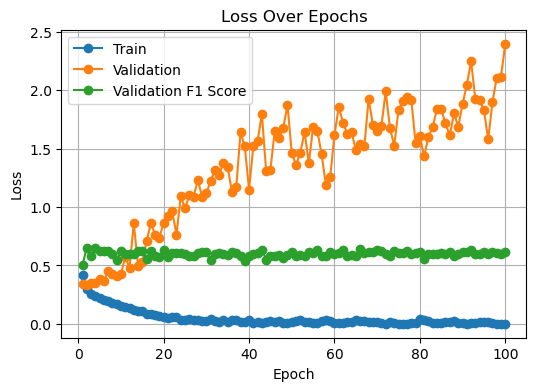

In [ ]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# classification report on the validation set

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions and labels
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
# Print the classification report
print(classification_report(y_true, y_pred, target_names=["No Seizure", "Seizure"]))



              precision    recall  f1-score   support

  No Seizure       0.93      0.88      0.90      2321
     Seizure       0.55      0.69      0.61       505

    accuracy                           0.84      2826
   macro avg       0.74      0.78      0.76      2826
weighted avg       0.86      0.84      0.85      2826



# Submission

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,
    signals_root=DATA_ROOT / "test",
    signal_transform=spectrogram_transform_2d,  # Use the same transform
    prefetch=True,
    return_id=True,
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed2.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
